In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import pandas as pd
import numpy as np
from keras.models import load_model
from research_lib.utils.data_access_utils import S3AccessUtils, RDSAccessUtils
from weight_estimation.dataset import prepare_gtsf_data, compute_akpd_score
from weight_estimation.train import train, augment, normalize, get_data_split, train_model
from typing import Dict, Tuple

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = false;

In [3]:
s3 = S3AccessUtils('data')
akpd_scorer_url = 'https://aquabyte-models.s3-us-west-1.amazonaws.com/keypoint-detection-scorer/akpd_scorer_model_TF.h5'
akpd_scorer_f, _, _ = s3.download_from_url(akpd_scorer_url)
#df1 = prepare_gtsf_data('2019-03-01', '2019-09-20', akpd_scorer_f, 0.5, 1.0)

#df2 = prepare_gtsf_data('2020-06-01', '2020-08-20', akpd_scorer_f, 0.5, 1.0)
#df = pd.concat([df1, df2])

In [4]:
df = pd.read_json('/Users/eskildh/Development/data/AKPD/akpd-trial.json').iloc[:15000]
len(df)

15000

In [ ]:
from filter_optimization.filter_optimization_task import extract_biomass_data

gt_metadata = {'pen_id': 144,
 'gutted_average_weight': 8000,
 'gutted_weight_distribution': None,
 'expected_loss_factor': 0.16,
 'last_feeding_date': '2021-01-11',
 'harvest_date': '2021-01-15',
 'slaughter_date': '2021-01-15'}

df2 = extract_biomass_data(gt_metadata['pen_id'], '2021-01-01', '2021-01-12', 0.01)

In [5]:
df.iloc[1000].keypoints

{'version': 1,
 'leftCrop': [{'xCrop': 193,
   'yCrop': 207,
   'xFrame': 1030,
   'yFrame': 261,
   'keypointType': 'UPPER_LIP'},
  {'xCrop': 245,
   'yCrop': 242,
   'xFrame': 1082,
   'yFrame': 296,
   'keypointType': 'EYE'},
  {'xCrop': 895,
   'yCrop': 350,
   'xFrame': 1732,
   'yFrame': 404,
   'keypointType': 'DORSAL_FIN'},
  {'xCrop': 1495,
   'yCrop': 956,
   'xFrame': 2332,
   'yFrame': 1010,
   'keypointType': 'ADIPOSE_FIN'},
  {'xCrop': 1867,
   'yCrop': 1506,
   'xFrame': 2704,
   'yFrame': 1560,
   'keypointType': 'TAIL_NOTCH'},
  {'xCrop': 1164,
   'yCrop': 1159,
   'xFrame': 2001,
   'yFrame': 1213,
   'keypointType': 'ANAL_FIN'},
  {'xCrop': 717,
   'yCrop': 863,
   'xFrame': 1554,
   'yFrame': 917,
   'keypointType': 'PELVIC_FIN'},
  {'xCrop': 321,
   'yCrop': 457,
   'xFrame': 1158,
   'yFrame': 511,
   'keypointType': 'PECTORAL_FIN'}],
 'rightCrop': [{'xCrop': 137,
   'yCrop': 221,
   'xFrame': 701,
   'yFrame': 257,
   'keypointType': 'UPPER_LIP'},
  {'xCrop': 181

In [ ]:
count

In [11]:
keypoints_new = []

count = 0

for index, row in df.iterrows():
    if count % 100 == 0:
        print(count, 'out of', len(df))

    count = count + 1
    
    #if count < 449:
    #    continue
        
    oL, oR, kpL, kpR, kpLScore, kpRScore, kpLScoreAvg, kpRScoreAvg, kpLScoreMax, kpRScoreMax = get_keypoints(row)
    
    newKeypoints = {
        'leftCrop': [],
        'rightCrop': []
    }
    
    for i in np.arange(0, len(KP), 1):
        newKeypoints['leftCrop'].append({
            'xCrop': oL[i][0],
            'yCrop': oL[i][1],
            'xCropNew': kpL[i][0],
            'yCropNew': kpL[i][1],
            'xFrame': oL[i][0] + row.left_crop_metadata['x_coord'],
            'yFrame': oL[i][1] + row.left_crop_metadata['y_coord'],
            'xFrameNew': kpL[i][0] + row.left_crop_metadata['x_coord'],
            'yFrameNew': kpL[i][1] + row.left_crop_metadata['y_coord'],
            'score': kpLScore[i],
            'scoreAvg': kpLScoreAvg[i],
            'scoreMax': kpLScoreMax[i],
            'keypointType': KP[i]
        })
        
        newKeypoints['rightCrop'].append({
            'xCrop': oR[i][0],
            'yCrop': oR[i][1],
            'xCropNew': kpR[i][0],
            'yCropNew': kpR[i][1],
            'xFrame': oR[i][0] + row.right_crop_metadata['x_coord'],
            'yFrame': oR[i][1] + row.right_crop_metadata['y_coord'],
            'xFrameNew': kpR[i][0] + row.right_crop_metadata['x_coord'],
            'yFrameNew': kpR[i][1] + row.right_crop_metadata['y_coord'],
            'score': kpRScore[i],
            'scoreAvg': kpRScoreAvg[i],
            'scoreMax': kpRScoreMax[i],
            'keypointType': KP[i]
        })
    
#     print(newKeypoints)
        
    keypoints_new.append(newKeypoints)

0 out of 15000
100 out of 15000
200 out of 15000
300 out of 15000
400 out of 15000
500 out of 15000
600 out of 15000
700 out of 15000
800 out of 15000
900 out of 15000
1000 out of 15000
1100 out of 15000
1200 out of 15000
1300 out of 15000
1400 out of 15000
1500 out of 15000
1600 out of 15000
1700 out of 15000
1800 out of 15000
1900 out of 15000
2000 out of 15000
2100 out of 15000
2200 out of 15000
2300 out of 15000
2400 out of 15000
2500 out of 15000
2600 out of 15000
2700 out of 15000
2800 out of 15000
2900 out of 15000
3000 out of 15000
3100 out of 15000
3200 out of 15000
3300 out of 15000
3400 out of 15000
3500 out of 15000
3600 out of 15000
3700 out of 15000
3800 out of 15000
3900 out of 15000
4000 out of 15000
4100 out of 15000
4200 out of 15000
4300 out of 15000
4400 out of 15000
4500 out of 15000
4600 out of 15000
4700 out of 15000
4800 out of 15000
4900 out of 15000
5000 out of 15000
5100 out of 15000
5200 out of 15000
5300 out of 15000
5400 out of 15000
5500 out of 15000
5600

In [12]:
len(keypoints_new)

15000

In [22]:
class NumpyFloatValuesEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.float32):
            return float(obj)
        return JSONEncoder.default(self, obj)

with open('/Users/eskildh/Development/data/AKPD/akpd-trial_newKP.json','w') as fp:
    json.dump(keypoints_new,fp, cls=NumpyFloatValuesEncoder)

In [ ]:
# config_bak_path = '/root/data/bati/model/config.json' 

In [ ]:
config

In [10]:
config_path = '/Users/eskildh/Development/data/AKPD/bati/model/production_config.json'
# config_path = '/root/data/bati/model/config_4_stage.json'

checkpoint_path = '/Users/eskildh/Development/data/AKPD/bati/model/model_499.pb'
config = json.load(open(config_path))

class FLAGS(object):
    input_size = tuple(config["input_size"])
    stages = config["cpm_stages"]
    batch_size = config["batch_size"]
    joints = config["num_of_joints"]
    model_path = checkpoint_path
    cmap_radius = config["center_radius"]
    keypoints_order = config["keypoints_order"]
    normalize = config["normalize"]
    heatmap_size = 512#config["heatmap_size"]
    joint_gaussian_variance = config["joint_gaussian_variance"]
    crop = config["crop"]
    augmentation = None
    
def load_pb(path_to_pb):
    with tf.io.gfile.GFile(path_to_pb, "rb") as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, input_map=None,
                                return_elements=None,
                                name="",
                                op_dict=None,
                                producer_op_list=None)
        graph_nodes=[n for n in graph_def.node]
#         for t in graph_nodes:
#             print(t.name)
        return graph

mod = load_pb(checkpoint_path)

sess = tf.compat.v1.Session()
tf.compat.v1.disable_eager_execution()

sess.graph.as_default()
sess.run(tf.compat.v1.global_variables_initializer())

tf_device = '/gpu:0'
with tf.device(tf_device):
    model = mod

Instructions for updating:
Please file an issue at https://github.com/tensorflow/tensorflow/issues if you depend on this feature.


In [6]:
import cv2
import urllib
import tensorflow as tf

def url_to_image(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image

def image_resize(image, FLAGS):
    height, width, _ = image.shape
    ratio_width = width / FLAGS.input_size[0]
    ratio_height = height / FLAGS.input_size[1]
    image = cv2.resize(image, FLAGS.input_size)
    image  = image / 255.0 - 0.5
    image = image[np.newaxis, ...]
    return image

def enhance(image, clip_limit=5):
    # convert image to LAB color model
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # split the image into L, A, and B channels
    l_channel, a_channel, b_channel = cv2.split(image_lab)

    # apply CLAHE to lightness channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L channel with the original A and B channel
    merged_channels = cv2.merge((cl, a_channel, b_channel))

    # convert image from LAB color model back to RGB color model
    final_image = cv2.cvtColor(merged_channels, cv2.COLOR_LAB2BGR)
    return final_image 


In [7]:
def get_keypoints(row):
    imL = row['left_image_url']
    imR = row['right_image_url']
    lco = row['left_crop_metadata']
    rco = row['right_crop_metadata']
    meta = row['camera_metadata']

    imageL = url_to_image(imL)
    imageR = url_to_image(imR)

    img1 = enhance(imageL)
    img2 = enhance(imageR)

    heightL, widthL, _ = img1.shape
    img_input = image_resize(img1, FLAGS)
    with tf.compat.v1.Session(graph=model) as sess, tf.device(tf_device):
        predict_heatmap = sess.run(config['output_name'], feed_dict = {config['input_name']: img_input})
    final_stage_heatmapL = predict_heatmap.squeeze()

    heightR, widthR, _ = img2.shape
    img_input = image_resize(img2, FLAGS)
    with tf.compat.v1.Session(graph=model) as sess, tf.device(tf_device):
        predict_heatmap = sess.run(config['output_name'], feed_dict = {config['input_name']: img_input})
    final_stage_heatmapR = predict_heatmap.squeeze()

    oL = []
    oR = []
    kpL = []
    kpR = []    
    kpLScore = []
    kpRScore = []
    kpLScoreAvg = []
    kpRScoreAvg = []
    kpLScoreMax = []
    kpRScoreMax = []

    for c in np.arange(0, len(KP), 1):
        hm = cv2.resize(final_stage_heatmapL[..., c], (widthL, heightL))
        hm_maxL = list(np.where(hm == hm.max()))   
        
        ii = np.unravel_index(np.argsort(hm.ravel())[-10000:], hm.shape)
        x = np.sum(np.exp(hm[ii]) * ii[1]) / np.sum(np.exp(hm[ii]))
        y = np.sum(np.exp(hm[ii]) * ii[0]) / np.sum(np.exp(hm[ii]))

        oL.append([int(hm_maxL[1][0]), int(hm_maxL[0][0])]) 
        kpL.append([int(np.rint(x)), int(np.rint(y))])
        kpLScore.append(hm[int(np.rint(y)), int(np.rint(x))])
        kpLScoreAvg.append(np.mean(hm[ii]))
        kpLScoreMax.append(hm.max())

        hm = cv2.resize(final_stage_heatmapR[..., c], (widthR, heightR))
        hm_maxR = np.where(hm == hm.max())
    
        ii = np.unravel_index(np.argsort(hm.ravel())[-10000:], hm.shape)
        x = np.sum(np.exp(hm[ii]) * ii[1]) / np.sum(np.exp(hm[ii]))
        y = np.sum(np.exp(hm[ii]) * ii[0]) / np.sum(np.exp(hm[ii]))

        oR.append([int(hm_maxR[1][0]), int(hm_maxR[0][0])])
        kpR.append([int(np.rint(x)), int(np.rint(y))])
        kpRScore.append(hm[int(np.rint(y)), int(np.rint(x))])
        kpRScoreAvg.append(np.mean(hm[ii]))
        kpRScoreMax.append(hm.max())

    return oL, oR, kpL, kpR, kpLScore, kpRScore, kpLScoreAvg, kpRScoreAvg, kpLScoreMax, kpRScoreMax 

In [ ]:
# print(int(np.rint(y)))
# hm[np.rint(y), np.rint(x)]
get_keypoints(row)

In [ ]:
config['input_name']='input_placeholder:0'
config['output_name']='stage_3/mid_conv7/BiasAdd:0'

# for row in df.iterrows():


# def get_keypoints(row):
    # row = df.iloc[0]
imL = row['left_image_url']
imR = row['right_image_url']
lco = row['left_crop_metadata']
rco = row['right_crop_metadata']
meta = row['camera_metadata']

# imL = row['left_crop_url']
# imR = row['right_crop_url']
# lco = row['left_crop_metadata']
# rco = row['right_crop_metadata']
# meta = row['camera_metadata']

imageL = url_to_image(imL)
imageR = url_to_image(imR)

img1 = enhance(imageL)
img2 = enhance(imageR)

heightL, widthL, _ = img1.shape
img_input = image_resize(img1, FLAGS)
with tf.compat.v1.Session(graph=model) as sess, tf.device(tf_device):
    predict_heatmap = sess.run(config['output_name'], feed_dict = {config['input_name']: img_input})
final_stage_heatmapL = predict_heatmap.squeeze()

heightR, widthR, _ = img2.shape
img_input = image_resize(img2, FLAGS)
with tf.compat.v1.Session(graph=model) as sess, tf.device(tf_device):
    predict_heatmap = sess.run(config['output_name'], feed_dict = {config['input_name']: img_input})
final_stage_heatmapR = predict_heatmap.squeeze()

# SIFT matching
MIN_MATCH_COUNT = 10
GOOD_PERC = 0.7
sift = cv2.KAZE_create()
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
good = []
for m,n in matches:
    if m.distance < GOOD_PERC*n.distance:
        good.append(m)
if len(good)>=MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
else:
    print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

Hx=M
Hy=np.linalg.inv(M)

kpL = []
kpR = []    
kpL2R = []
kpR2L = [] 
im1ps = []
im2ps = []
gtL2R = []
gtR2L = [] 
gt1ps = []
gt2ps = []

for c in np.arange(0, len(KP), 1):
    hm = cv2.resize(final_stage_heatmapL[..., c], (widthL, heightL))

    hm_maxL = list(np.where(hm == hm.max()))   
    kpL.append([int(hm_maxL[1][0]), int(hm_maxL[0][0])]) 
    ptx=np.array([kpL[c][0],kpL[c][1],1])
    zx=np.dot(Hx,ptx)
    kpL2R.append([int(zx[0]/zx[2]), int(zx[1]/zx[2])]) 

    hm = cv2.resize(final_stage_heatmapR[..., c], (widthR, heightR))
    hm_maxR = np.where(hm == hm.max())
    kpR.append([int(hm_maxR[1][0]), int(hm_maxR[0][0])])
    pty=np.array([kpR[c][0],kpR[c][1],1])
    zy=np.dot(Hy,pty)
    kpR2L.append([int(zy[0]/zy[2]), int(zy[1]/zy[2])]) 

    im1ps.append([int((kpL[c][0]+kpR2L[c][0])/2), int((kpL[c][1]+kpR2L[c][1])/2)]) 
    im2ps.append([int((kpR[c][0]+kpL2R[c][0])/2), int((kpR[c][1]+kpL2R[c][1])/2)]) 
        
#     return kpL, kpR, im1ps, im2ps, final_stage_heatmapL, final_stage_heatmapR

In [ ]:
refined_keypoints_left = []
refined_keypoints_right = []

for c in np.arange(0, len(KP), 1):
    hm = cv2.resize(final_stage_heatmapL[..., c], (widthL, heightL))
    ii = np.unravel_index(np.argsort(hm.ravel())[-10000:], hm.shape)
    # list(np.where(hm == hm.max()))
    x = np.sum(np.exp(hm[ii]) * ii[1]) / np.sum(np.exp(hm[ii]))
    y = np.sum(np.exp(hm[ii]) * ii[0]) / np.sum(np.exp(hm[ii]))
    
    refined_keypoints_left.append([np.rint(x), np.rint(y)])

    hm = cv2.resize(final_stage_heatmapR[..., c], (widthR, heightR))
    ii = np.unravel_index(np.argsort(hm.ravel())[-10000:], hm.shape)
    # list(np.where(hm == hm.max()))
    x = np.sum(np.exp(hm[ii]) * ii[1]) / np.sum(np.exp(hm[ii]))
    y = np.sum(np.exp(hm[ii]) * ii[0]) / np.sum(np.exp(hm[ii]))
    
    refined_keypoints_right.append([np.rint(x), np.rint(y)])
    
    #ii
# X = x / hmL.shape[0] * row.left_crop_metadata['width']
# Y = y / hmL.shape[1] * row.left_crop_metadata['height']

In [ ]:
#np.exp(hm[ii])

In [ ]:
x, y

In [ ]:
refined_keypoints_right

In [ ]:
list(np.where(hm == hm.max()))

In [ ]:
x = np.sum(np.exp(hm[ii]) * ii[1]) / np.sum(np.exp(hm[ii]))
y = np.sum(np.exp(hm[ii]) * ii[0]) / np.sum(np.exp(hm[ii]))
x, y

In [ ]:
hm[112, 1174], hm[111, 1154], hm.max()

In [ ]:
for c in np.arange(0, len(KP), 1):
    hm = cv2.resize(final_stage_heatmapL[..., c], (widthL, heightL))
    print(KP[c], hm.max())

In [ ]:
kpL, kpR, im1ps, im2ps, final_stage_heatmapL, final_stage_heatmapR = get_keypoints(df2.iloc[2])

In [ ]:
im1ps

In [ ]:
kpL

In [8]:
def display_crops(left_image_f, right_image_f, ann, overlay_keypoints=True, show_labels=False, custom_kps_left = [], custom_kps_right = []):
    fig, axes = plt.subplots(2, 1, figsize=(20, 20))
    left_image = plt.imread(left_image_f)
    right_image = plt.imread(right_image_f)
    axes[0].imshow(left_image)
    axes[1].imshow(right_image)
    left_ann, right_ann = ann['leftCrop'], ann['rightCrop']
    left_keypoints = {item['keypointType']: [item['xCrop'], item['yCrop']] for item in left_ann}
    right_keypoints = {item['keypointType']: [item['xCrop'], item['yCrop']] for item in right_ann}
    if overlay_keypoints:
        for bp, kp in left_keypoints.items():
            axes[0].scatter([kp[0]], [kp[1]], color='red', s=10)
            if show_labels:
                axes[0].annotate(bp, (kp[0], kp[1]), color='red')
        for bp, kp in custom_kps_left.items():
            axes[0].scatter([kp[0]], [kp[1]], color='cyan', s=10)
            if show_labels:
                axes[0].annotate(bp, (kp[0], kp[1]), color='cyan')
        for bp, kp in right_keypoints.items():
            axes[1].scatter([kp[0]], [kp[1]], color='red', s=10)
            if show_labels:
                axes[1].annotate(bp, (kp[0], kp[1]), color='red')
        for bp, kp in custom_kps_right.items():
            axes[1].scatter([kp[0]], [kp[1]], color='cyan', s=10)
            if show_labels:
                axes[1].annotate(bp, (kp[0], kp[1]), color='cyan')
    plt.show()

In [ ]:
import ast, os
from research.weight_estimation.keypoint_utils.optics import pixel2world
import matplotlib.pyplot as plt

s3 = S3AccessUtils('/root/data', json.load(open(os.environ['AWS_CREDENTIALS'])))

left_crop_url, right_crop_url = row.left_image_url, row.right_image_url
ann, cm = row.keypoints, row.camera_metadata

# left_crop_url, right_crop_url = row.left_crop_url, row.right_crop_url
# ann, cm = row.annotation, row.camera_metadata

left_crop_f, _, _ = s3.download_from_url(left_crop_url)
right_crop_f, _, _ = s3.download_from_url(right_crop_url)
wkps1 = pixel2world(ann['leftCrop'], ann['rightCrop'], cm)

In [33]:
oDists = {}
nDists = {}

for kp in KP:
    oDists[kp] = []
    nDists[kp] = []

cnt = 0
    
for index, row in df.iterrows():
    
    if ('leftCrop' not in row.keypoints) or ('rightCrop' not in row.keypoints):
        cnt = cnt + 1
        continue
    
    for i in np.arange(0, len(KP)):
        newKeypointLeft = [kp for kp in keypoints_new[cnt]['leftCrop'] if kp['keypointType'] == KP[i]][0]
        newKeypointRight = [kp for kp in keypoints_new[cnt]['rightCrop'] if kp['keypointType'] == KP[i]][0]
    
        gtKeypoint = [kp for kp in row.keypoints['leftCrop'] if kp['keypointType'] == KP[i]][0]
        gtX = gtKeypoint['xCrop']
        gtY = gtKeypoint['yCrop']

        oX = newKeypointLeft['xCrop']
        oY = newKeypointLeft['yCrop']

        nX = newKeypointLeft['xCropNew']
        nY = newKeypointLeft['yCropNew']
        
        oDist = np.abs(gtX - oX) + np.abs(gtY - oY)
        nDist = np.abs(gtX - nX) + np.abs(gtY - nY)

        oDists[KP[i]].append(oDist)
        nDists[KP[i]].append(nDist)

        gtKeypoint = [kp for kp in row.keypoints['rightCrop'] if kp['keypointType'] == KP[i]][0]
        gtX = gtKeypoint['xCrop']
        gtY = gtKeypoint['yCrop']

        oX = newKeypointRight['xCrop']
        oY = newKeypointRight['yCrop']

        nX = newKeypointRight['xCropNew']
        nY = newKeypointRight['yCropNew']

        oDist = np.abs(gtX - oX) + np.abs(gtY - oY)
        nDist = np.abs(gtX - nX) + np.abs(gtY - nY)

        oDists[KP[i]].append(oDist)
        nDists[KP[i]].append(nDist)

    cnt = cnt + 1
    
    #if cnt >= 449:
    #    break
#     np.mean(oDists), np.mean(nDists)

In [41]:
kp, len(oDists[kp])

('DORSAL_FIN', 29942)

In [34]:
oDists[kp]

[21,
 11,
 46,
 13,
 26,
 5,
 21,
 37,
 7,
 12,
 31,
 16,
 13,
 62,
 5,
 38,
 4,
 30,
 39,
 13,
 16,
 21,
 5,
 14,
 7,
 10,
 16,
 33,
 12,
 16,
 12,
 40,
 22,
 32,
 6,
 60,
 5,
 11,
 51,
 39,
 34,
 23,
 137,
 8,
 27,
 10,
 21,
 56,
 19,
 17,
 36,
 10,
 8,
 17,
 13,
 16,
 22,
 12,
 15,
 1,
 34,
 21,
 31,
 10,
 14,
 16,
 37,
 10,
 31,
 16,
 15,
 2,
 13,
 15,
 40,
 6,
 7,
 12,
 15,
 43,
 28,
 10,
 12,
 33,
 7,
 12,
 43,
 53,
 157,
 15,
 37,
 11,
 29,
 14,
 28,
 12,
 16,
 10,
 62,
 94,
 2,
 26,
 49,
 42,
 49,
 42,
 16,
 15,
 36,
 16,
 378,
 416,
 32,
 18,
 72,
 28,
 46,
 60,
 28,
 27,
 24,
 55,
 26,
 34,
 40,
 8,
 5,
 26,
 9,
 19,
 17,
 10,
 24,
 27,
 28,
 16,
 32,
 15,
 8,
 6,
 14,
 13,
 14,
 35,
 18,
 63,
 9,
 5,
 11,
 14,
 37,
 22,
 8,
 24,
 11,
 17,
 38,
 27,
 44,
 19,
 40,
 11,
 20,
 34,
 20,
 56,
 34,
 18,
 10,
 11,
 17,
 21,
 55,
 36,
 11,
 8,
 7,
 28,
 52,
 48,
 9,
 12,
 38,
 6,
 12,
 11,
 13,
 5,
 33,
 269,
 6,
 23,
 34,
 11,
 5,
 16,
 15,
 30,
 22,
 5,
 13,
 15,
 6,
 37,
 13,
 15

In [35]:
for kp in KP:
#     print(np.mean(oDists[kp]), np.mean(nDists[kp]))
    print(kp, np.median(oDists[kp]), np.median(nDists[kp]), 2 * (np.median(nDists[kp]) - np.median(oDists[kp])) / np.median(nDists[kp]) + np.median(oDists[kp]))

TAIL_NOTCH 21.0 18.0 20.666666666666668
ADIPOSE_FIN 17.0 13.0 16.384615384615383
UPPER_LIP 16.0 17.0 16.11764705882353
ANAL_FIN 14.0 10.0 13.2
PELVIC_FIN 14.0 11.0 13.454545454545455
EYE 13.0 12.0 12.833333333333334
PECTORAL_FIN 16.0 12.0 15.333333333333334
DORSAL_FIN 20.0 17.0 19.647058823529413


In [68]:
stats = [
    {
        'keypoint':kp,
        'samples':int(len(oDists[kp])/2),
        'max_heat': { 
            'med':np.median(oDists[kp]),
            'mean': np.mean(oDists[kp]),
            'max': np.max(oDists[kp])
        },
        'avg_heat': { 
            'med':np.median(nDists[kp]),
            'mean': np.mean(nDists[kp]),
            'max': np.max(nDists[kp])
        },
        'med_var': 2 * (np.median(nDists[kp]) - np.median(oDists[kp])) / np.median(nDists[kp]) + np.median(oDists[kp])
    } for kp in KP]
stats

[{'keypoint': 'TAIL_NOTCH',
  'samples': 14971,
  'max_heat': {'med': 21.0, 'mean': 29.80458887181885, 'max': 4389},
  'avg_heat': {'med': 18.0, 'mean': 30.426858593280343, 'max': 3970},
  'med_var': 20.666666666666668},
 {'keypoint': 'ADIPOSE_FIN',
  'samples': 14971,
  'max_heat': {'med': 17.0, 'mean': 23.77790394763209, 'max': 3285},
  'avg_heat': {'med': 13.0, 'mean': 21.944025115222765, 'max': 3211},
  'med_var': 16.384615384615383},
 {'keypoint': 'UPPER_LIP',
  'samples': 14971,
  'max_heat': {'med': 16.0, 'mean': 21.34135996259435, 'max': 4271},
  'avg_heat': {'med': 17.0, 'mean': 39.191169594549464, 'max': 3407},
  'med_var': 16.11764705882353},
 {'keypoint': 'ANAL_FIN',
  'samples': 14971,
  'max_heat': {'med': 14.0, 'mean': 17.29937879901142, 'max': 2809},
  'avg_heat': {'med': 10.0, 'mean': 14.270422817447065, 'max': 2421},
  'med_var': 13.2},
 {'keypoint': 'PELVIC_FIN',
  'samples': 14971,
  'max_heat': {'med': 14.0, 'mean': 16.81801482866876, 'max': 2312},
  'avg_heat': {'

In [63]:
class NumpyIntValuesEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int64):
            return int(obj)
        return JSONEncoder.default(self, obj)
with open('/Users/eskildh/Development/data/AKPD/akpd-trial_stats.json','w') as fp:
    json.dump(stats,fp,cls=NumpyIntValuesEncoder)

In [16]:
newKeypointLeft = [kp for kp in keypoints_new[2]['leftCrop'] if kp['keypointType'] == 'TAIL_NOTCH'][0]
newKeypointLeft

{'xCrop': 2723,
 'yCrop': 423,
 'xCropNew': 2728,
 'yCropNew': 419,
 'xFrame': 3578,
 'yFrame': 1115,
 'xFrameNew': 3583,
 'yFrameNew': 1111,
 'score': 0.60389906,
 'scoreAvg': 0.28318653,
 'scoreMax': 0.6486691,
 'keypointType': 'TAIL_NOTCH'}

In [ ]:
df.iloc[2].keypoints

In [ ]:
# display_crops(left_crop_f, right_crop_f, ann, True, True)

custom_kps_left = {}
custom_kps_right = {}

for i, item in enumerate(refined_keypoints_left):
    custom_kps_left[KP[i]] = (item[0], item[1])
    
for i, item in enumerate(refined_keypoints_right):
    custom_kps_right[KP[i]] = (item[0], item[1])

display_crops(left_crop_f, right_crop_f, ann, True, False, custom_kps_left, custom_kps_right)

In [ ]:
# display_crops(left_crop_f, right_crop_f, ann, True, True)

custom_kps_left = {}
custom_kps_right = {}

for i, item in enumerate(kpL):
    custom_kps_left[KP[i]] = (item[0], item[1])
    
for i, item in enumerate(kpR):
    custom_kps_right[KP[i]] = (item[0], item[1])

display_crops(left_crop_f, right_crop_f, ann, True, False, custom_kps_left, custom_kps_right)

NameError: name 'final_stage_heatmapL' is not defined

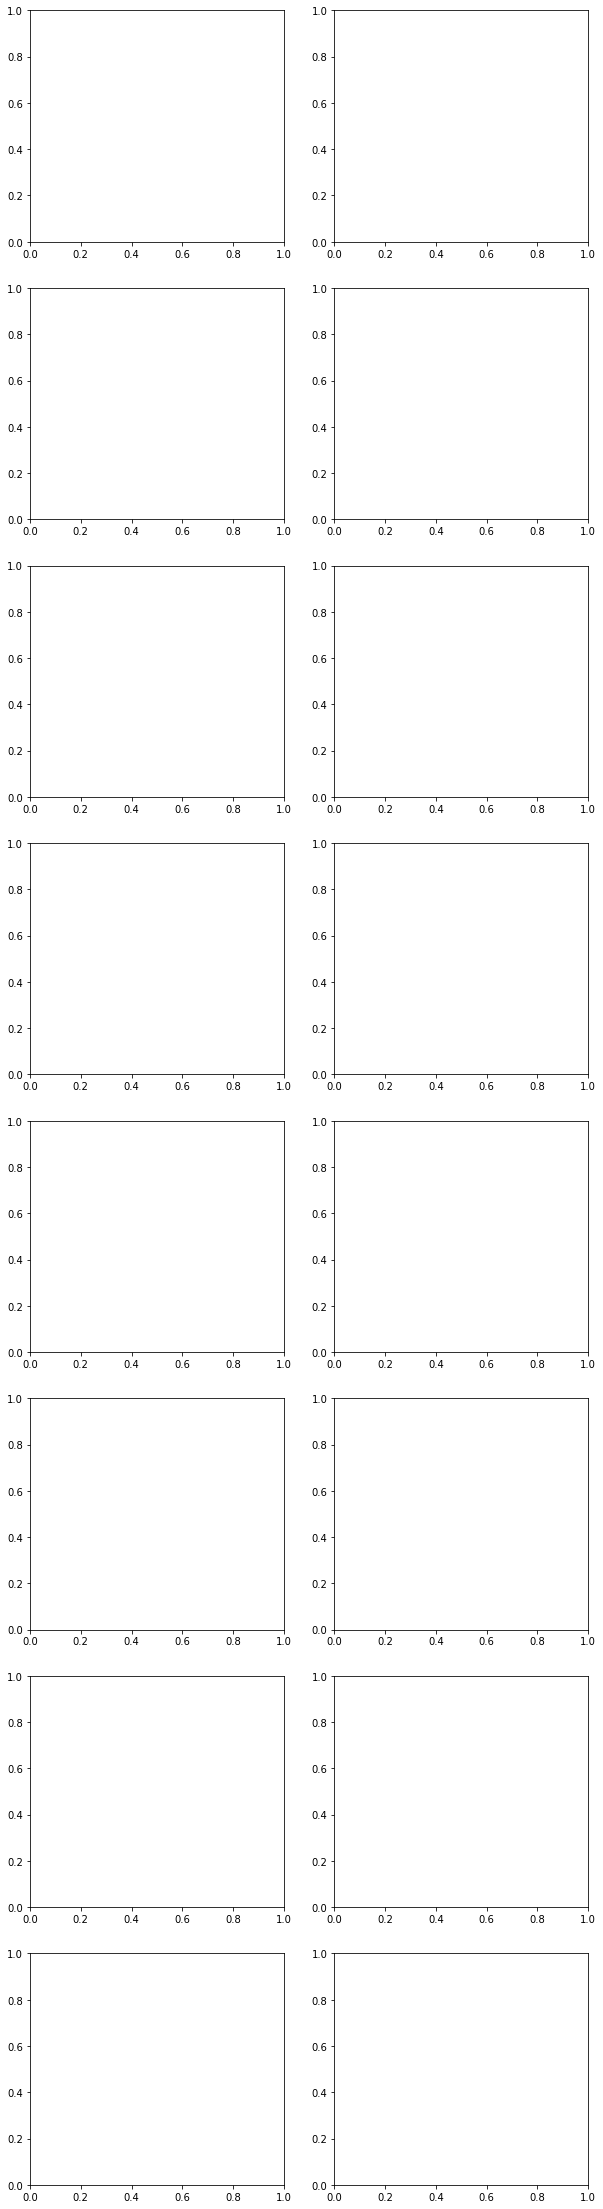

In [9]:
KP = ["TAIL_NOTCH", "ADIPOSE_FIN", "UPPER_LIP", "ANAL_FIN", "PELVIC_FIN", "EYE", "PECTORAL_FIN", "DORSAL_FIN"]

fig, axes = plt.subplots(len(KP), 2, figsize=(2 * 5, len(KP) * 5))

for i in np.arange(0, len(KP), 1):
    axes[i, 0].imshow(final_stage_heatmapL[:,:,i], cmap='hot', interpolation='nearest')
    axes[i, 0].set_title('%s %s' % (KP[i], 'Left'))
    axes[i, 1].imshow(final_stage_heatmapR[:,:,i], cmap='hot', interpolation='nearest')
    axes[i, 1].set_title('%s %s' % (KP[i], 'Right'))


In [ ]:
# i = KP.index('UPPER_LIP')
i = 0

hmL = final_stage_heatmapL[:,:,i]

plt.imshow(hmL, cmap='hot', interpolation='nearest')

In [ ]:
from numpy import unravel_index

Y, X = unravel_index(hmL.argmax(), hmL.shape)

X, Y

In [ ]:
X / hmL.shape[0] * row.left_crop_metadata['width']

In [ ]:
Y / hmL.shape[1] * row.left_crop_metadata['height']

In [ ]:
gt_keypoints = row.keypoints['leftCrop']
[ kp for kp in gt_keypoints if kp['keypointType'] == KP[i] ]

In [ ]:
row.camera_metadata

In [ ]:
row.left_crop_metadata